## I. Import Libraries

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
import re
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ufcdataset/data.csv


In [2]:
# Import data

data = pd.read_csv('/kaggle/input/ufcdataset/data.csv')

## 2. Brief EDA

In [3]:
print(data.shape)
data.describe

(2318, 894)


<bound method NDFrame.describe of       BPrev  BStreak  B_Age  B_Height                             B_HomeTown  \
0         0        0   38.0     193.0                       Hounslow England   
1         0        0   36.0     172.0        Chicago, Illinois United States   
2         0        0   39.0     167.0            Isla Vista , California USA   
3         0        0   33.0     167.0                      San Diego, CA USA   
4         0        0   36.0     185.0                    Southampton England   
...     ...      ...    ...       ...                                    ...   
2313      7        0   34.0     172.0           El Paso, Texas United States   
2314      9        1   31.0     177.0     Milwaukee, Wisconsin United States   
2315      5        3   35.0     180.0                        Amazonas Brazil   
2316      1        0   37.0     170.0  Moses Lake, Washington United States    
2317      0        0   23.0     190.0  Los Angeles, California United States   

     

## 3. Data Cleaning

In [4]:
data.isnull().sum(axis=0)

BPrev                                 0
BStreak                               0
B_Age                                17
B_Height                             17
B_HomeTown                           17
                                   ... 
R__Round5_TIP_Neutral Time         2048
R__Round5_TIP_Side Control Time    2048
R__Round5_TIP_Standing Time        2048
winby                                36
winner                                0
Length: 894, dtype: int64

In [5]:
# Removing columns with >30 % null values.

nulls = []
for i in data.columns:
    counts = data[i].isnull().sum()
    if (counts / len(data)) * 100 > 30:
        nulls.append(i)

len(nulls)

617

In [6]:
dropdata = data.drop(nulls,axis=1)

In [7]:
# Time to delete columns that have no predictive power.

In [8]:
dropdata = dropdata.drop(['B_ID','B_Name','R_ID','R_Name','winby','Date','B_HomeTown','B_Location','R_HomeTown','R_Location'],axis=1)

In [9]:
dropdata.shape

(2318, 267)

In [10]:
master = dropdata

In [11]:
print

<function print>

In [12]:
# Filling in NaN's with median value for the column.

master.fillna(master.median(), inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Printing total NaN's for all columns.  Shoutout to Charles B. (Kaggle) for the code.

print("Total NaN in dataframe :" , master.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(master):
    na.append((index, master[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(master.columns)):
    print(master.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
BPrev : 0 NaN
BStreak : 0 NaN
B_Age : 0 NaN
B_Height : 0 NaN
B_Weight : 0 NaN
B__Round1_Grappling_Reversals_Landed : 0 NaN
B__Round1_Grappling_Standups_Landed : 0 NaN
B__Round1_Grappling_Submissions_Attempts : 0 NaN
B__Round1_Grappling_Takedowns_Attempts : 0 NaN
B__Round1_Grappling_Takedowns_Landed : 0 NaN
B__Round1_Strikes_Body Significant Strikes_Attempts : 0 NaN
B__Round1_Strikes_Body Significant Strikes_Landed : 0 NaN
B__Round1_Strikes_Body Total Strikes_Attempts : 0 NaN
B__Round1_Strikes_Body Total Strikes_Landed : 0 NaN
B__Round1_Strikes_Clinch Body Strikes_Attempts : 0 NaN
B__Round1_Strikes_Clinch Body Strikes_Landed : 0 NaN
B__Round1_Strikes_Clinch Head Strikes_Attempts : 0 NaN
B__Round1_Strikes_Clinch Head Strikes_Landed : 0 NaN
B__Round1_Strikes_Clinch Leg Strikes_Attempts : 0 NaN
B__Round1_Strikes_Clinch Leg Strikes_Landed : 0 NaN
B__Round1_Strikes_Clinch Significant Kicks_Attempts : 0 NaN
B__Round1_Strikes

In [14]:
# Checking the timeframe of the fight data to ensure no fight data is prior to the unified rules adoption in April 2001.

print(data['Date'].min())
print((data['Date'].max()))

01/01/2018
24/10/2015


### Dropping all "draw" and "no contests" from target variable so that we're left with only red winner or blue winner.

In [15]:
master.drop(master.index[master['winner'] == 'draw'], inplace = True)

In [16]:
master.drop(master.index[master['winner'] == 'no contest'], inplace = True)

In [17]:
# Target variable is either "red" or "blue" (the winner of the fight).  Transforming to "1" and "0".

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

le = LabelEncoder()
master['winner'] = le.fit_transform(master['winner'])

In [18]:
# Creating our test and train datasets

X = master.drop(['winner'], axis=1)
y = master['winner']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=25)

In [20]:
X_train.shape, X_test.shape

((1822, 266), (456, 266))

In [21]:
# Checking data types

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X_train.dtypes)

BPrev                                                      int64
BStreak                                                    int64
B_Age                                                    float64
B_Height                                                 float64
B_Weight                                                 float64
B__Round1_Grappling_Reversals_Landed                     float64
B__Round1_Grappling_Standups_Landed                      float64
B__Round1_Grappling_Submissions_Attempts                 float64
B__Round1_Grappling_Takedowns_Attempts                   float64
B__Round1_Grappling_Takedowns_Landed                     float64
B__Round1_Strikes_Body Significant Strikes_Attempts      float64
B__Round1_Strikes_Body Significant Strikes_Landed        float64
B__Round1_Strikes_Body Total Strikes_Attempts            float64
B__Round1_Strikes_Body Total Strikes_Landed              float64
B__Round1_Strikes_Clinch Body Strikes_Attempts           float64
B__Round1_Strikes_Clinch 

## 4. Modeling. Going to model the fights with three different models:
* Random Forest Classifier model
* Linear Regression
* Gradient Boosting Regressor

## Random Forest Classifier Model

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)

rfc.fit(X_train, y_train)

y_pred_rfc=rfc.predict(X_test)

print(mean_absolute_error(y_test,y_pred_rfc))

0.40789473684210525


## Linear Regression

In [23]:
reg = LinearRegression().fit(X_train,y_train)

y_pred_reg = reg.predict(X_test)

print(mean_absolute_error(y_test,y_pred_reg))

0.46555986578929964


## Gradient Boosting Regressor

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingRegressor(random_state = 0)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print(mean_absolute_error(y_test,y_pred_gb))

0.4688291619123302


### The Random Forest Classifier model has the lowest mean absolute error (mean difference between predict and observed y-values.)

## 5. Feature Engineering and Visualization

In [25]:
features = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

features

Fight_ID                                               0.030757
B_Age                                                  0.028951
Event_ID                                               0.026481
R_Age                                                  0.025865
R_Height                                               0.019173
                                                         ...   
R__Round2_Strikes_Ground Leg Strikes_Attempts          0.000406
B__Round1_Strikes_Ground Significant Kicks_Attempts    0.000406
B__Round1_Strikes_Ground Significant Kicks_Landed      0.000335
R__Round1_Strikes_Ground Significant Kicks_Landed      0.000285
R__Round2_Strikes_Ground Significant Kicks_Landed      0.000254
Length: 266, dtype: float64

<AxesSubplot:>

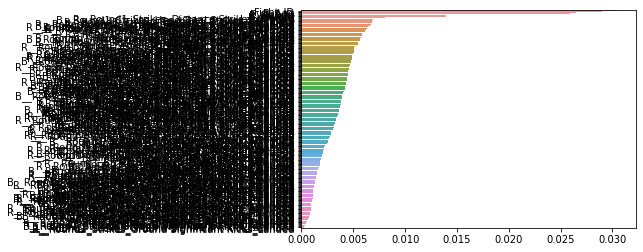

In [26]:
sns.barplot(x=features, y=features.index)

### Clearly no feature alone has huge explanatory power. 